In [1]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from matplotlib import pyplot as plt
from scipy import fftpack
from matplotlib.pyplot import figure
import datetime
import time

# Example time series definition

<AxesSubplot:>

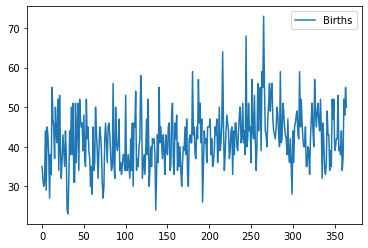

In [3]:
stationary_series = read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv", header=0, index_col=0)
stationary_series.reset_index(inplace=True)
stationary_series.plot()

<AxesSubplot:>

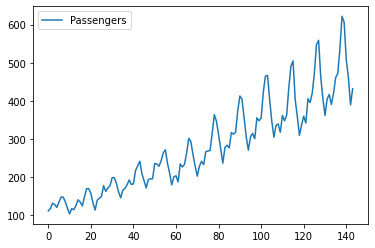

In [4]:
nonstationary_series = read_csv("https://raw.githubusercontent.com/2wavetech/How-to-Check-if-Time-Series-Data-is-Stationary-with-Python/master/international-airline-passengers.csv")
nonstationary_series.columns.values[1] = "Passengers"
nonstationary_series.dropna(inplace = True)
nonstationary_series.plot()


<AxesSubplot:xlabel='Time'>

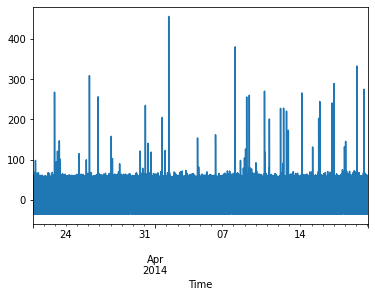

In [5]:
dataset_name = "House20.csv"

periodic_timeseries = read_csv("AnnotatorTOOL/data/REFIT/" + dataset_name)
periodic_timeseries['Appliance1'] = periodic_timeseries['Appliance1'] - periodic_timeseries['Appliance1'].mean()

periodic_timeseries.index = pd.to_datetime(periodic_timeseries["Time"])

periodic_timeseries = periodic_timeseries.resample("1min").mean()

periodic_timeseries.fillna(0, inplace = True)

periodic_timeseries['Appliance1'][791:43991].plot()

In [6]:
periodic_timeseries["Time"] = periodic_timeseries.index.strftime("%Y-%m-%d %H:%M:%S")

In [7]:
periodic_timeseries

,Appliance1,Issues,Time
Time,,,
2014-03-20 12:01:00,48.280421,0.0,2014-03-20 12:01:00
2014-03-20 12:02:00,47.994707,0.0,2014-03-20 12:02:00
2014-03-20 12:03:00,46.980421,0.0,2014-03-20 12:03:00
2014-03-20 12:04:00,31.580421,0.0,2014-03-20 12:04:00
2014-03-20 12:05:00,-35.719579,0.0,2014-03-20 12:05:00
...,...,...,...
2015-06-23 19:40:00,44.280421,0.0,2015-06-23 19:40:00
2015-06-23 19:41:00,44.391532,0.0,2015-06-23 19:41:00
2015-06-23 19:42:00,44.613754,0.0,2015-06-23 19:42:00


# 1. Check if the time series is stationary

In [8]:
def check_stationarity(time_series, max_p_value = 0.0005, print_p_value = True):
  '''
  time_series must be a pandas column (e.g., df['power'])
  max_p_value is the maximum p-value for which the time series is considered stationary (default 0.0005)
  '''
  result = adfuller(time_series)
  pvalue = result[1]
  print("The p-value is %.4f" %pvalue)
  if pvalue < max_p_value:
    return True
  else:
    return False

In [9]:
check_stationarity(stationary_series['Births'])

The p-value is 0.0001


True

In [10]:
check_stationarity(nonstationary_series['Passengers'])

The p-value is 0.9919


False

# Look for anomalies in a stationary time series

In [11]:
def get_anomalies_stationary(time_series, global_window_size, global_window_stride, local_window_size, local_window_stride, threshold = 0.2):
  '''
  The sizes must be expressed in number of samples
  '''
 
  anomalies = []

  max_start_global_window = len(time_series) - global_window_size

  for start_sample in range(0, max_start_global_window + global_window_size, global_window_stride):
    global_mean = time_series[start_sample:(start_sample+global_window_size)].mean()

    max_start_local_window = global_window_size - local_window_size + start_sample

    for start_local_sample in range(start_sample, max_start_local_window + local_window_size, local_window_stride):
      local_mean = time_series[start_local_sample:(start_local_sample+local_window_size)].mean()
      
      RMean = (np.abs(local_mean - global_mean)/global_mean)

      if RMean > threshold:
        print("Anomaly in the local window in the sample range [%d, %d]" %(start_local_sample, start_local_sample+local_window_size))
        anomalies.append([start_local_sample, start_local_sample+local_window_stride])

  return anomalies

In [12]:
get_anomalies_stationary(stationary_series['Births'], 15, 10, 4, 2)

Anomaly in the local window in the sample range [12, 16]
Anomaly in the local window in the sample range [30, 34]
Anomaly in the local window in the sample range [264, 268]


[[12, 14], [30, 32], [264, 266]]

# Look for anomalies in periodic time series

In [13]:
def get_sampling_time_seconds(timestamps, timestamp_format):
  # Determine sampling time
  time_0 = datetime.datetime.strptime(timestamps[0], timestamp_format)
  time_1 = datetime.datetime.strptime(timestamps[1], timestamp_format)
  time_interval = time_1 - time_0
  time_interval_seconds = time_interval.total_seconds()
  return time_interval_seconds

In [14]:
def plot_timeseries(time_series, timestamps, timestamp_format, first_N_timestamps):
  timestamp_seconds = get_sampling_time_seconds(timestamps, timestamp_format)
  # Save the plot of the first cycles
  fig = plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(np.arange(first_N_timestamps)*timestamp_seconds, time_series[:first_N_timestamps])
  plt.title('Power variation in a sequence of cycles')
  plt.xlabel('Seconds')
  plt.ylabel('Power')
  plt.savefig("timeseries.pdf", dpi=80)

In [15]:
def plot_fft(xf, yf):
  # Save the plot of the FFT of the test set
  fig = plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(xf, np.abs(yf))
  plt.yscale('log')
  plt.xscale('log')
  plt.title('Power spectrum')
  plt.xlabel('Frequency')
  plt.ylabel('Power')
  plt.savefig("fft.pdf", dpi=80)
  

In [23]:
def get_main_period(xf, yf):
  xf, yf = xf[1:], yf[1:]
  max_idx = np.argmax(np.abs(yf)) # get the maximum power in the FFT
  p = 1/xf[max_idx] # get the period (1/frequency) associated with the maximum power
  return p

In [32]:
def get_anomalies_periodicity(time_series, timestamps, timestamp_format, amount_normal_samples, out_name, pearson_threshold = 0.99999, ratio_threshold = 2.5, offset_test = 44640, duration_test = 44640):
  ''' amount_normal_samples is the number of samples assumed to be normal (i.e., without anomalies)
  pearson_threshold is the minimum value of the Pearson product-moment coefficient to have a periodic series
  ratio_threshold is the minimum value of RStd to have an anomaly
  '''
  timestamps = timestamps.values
  confidences = np.array([0]*len(timestamps))

  anomalies = []
  
  N = amount_normal_samples

  # Compute the FFT of the test set
  yf = fft(time_series[:amount_normal_samples].values)
  xf = fftfreq(N, 1)
    
  mask = [idx for idx, val in enumerate(xf) if val >= 0] # create a mask to take only the positive frequencies (the FFT is symmetric)

  yf = yf[mask]
  
  time_interval_seconds = get_sampling_time_seconds(timestamps, timestamp_format)
  xf = xf[mask]/time_interval_seconds # convert to Hz

  p = get_main_period(xf, yf)
  p_samples = p/time_interval_seconds # period in samples

  plot_timeseries(time_series, timestamps, timestamp_format, int(3*p_samples))
  plot_fft(xf, yf)
    
  print("The period is %.4f seconds, or %.4f samples" %(p, p_samples))

  number_of_periods = int(len(time_series)/p_samples)

  for period_no in range(0, number_of_periods-1):
    int_period = int(p_samples)
    start_p = int(period_no*p_samples)
    end_first_p = start_p + int_period
    end_second_p = start_p + int_period*2
    
    Y = time_series[int(start_p):int(end_first_p)]
    Z = time_series[int(end_first_p):int(end_second_p)]

    pearson = np.corrcoef(Y.values, Z.values)

    if pearson[0,1] > pearson_threshold and start_p <= amount_normal_samples:
      print("The series is not periodic in samples interval [%d, %d]" %(start_p, end_second_p))

    std_current = np.std(Z)
    std_previous = np.std(Y)
    
    Rstd = abs(std_current-std_previous)/std_previous

    if Rstd > ratio_threshold:
       anomalies.append([int(end_first_p), int(end_second_p)])
       print("Anomaly in samples interval [%d, %d]" %(end_first_p, end_second_p))
        
  for anomaly in anomalies:
    confidences[anomaly[0]:anomaly[1]] = 1
    
  df = pd.DataFrame({'ctime': timestamps, 'confidence': confidences})
  df = df.set_index(['ctime'])
  df = df.iloc[(N+offset_test):(N+offset_test+duration_test)]
  print(df)
  df.to_csv(out_name)
  
  

In [33]:
periodic_timeseries['Time'][719:]

Time
2014-03-21 00:00:00    2014-03-21 00:00:00
2014-03-21 00:01:00    2014-03-21 00:01:00
2014-03-21 00:02:00    2014-03-21 00:02:00
2014-03-21 00:03:00    2014-03-21 00:03:00
2014-03-21 00:04:00    2014-03-21 00:04:00
                              ...         
2015-06-23 19:40:00    2015-06-23 19:40:00
2015-06-23 19:41:00    2015-06-23 19:41:00
2015-06-23 19:42:00    2015-06-23 19:42:00
2015-06-23 19:43:00    2015-06-23 19:43:00
2015-06-23 19:44:00    2015-06-23 19:44:00
Freq: T, Name: Time, Length: 662145, dtype: object

The period is 2965.6751 seconds, or 49.4279 samples
Anomaly in samples interval [1334, 1383]
Anomaly in samples interval [1927, 1976]
Anomaly in samples interval [4102, 4151]
Anomaly in samples interval [5584, 5633]
Anomaly in samples interval [5683, 5732]
Anomaly in samples interval [7660, 7709]
Anomaly in samples interval [9835, 9884]
Anomaly in samples interval [12751, 12800]
Anomaly in samples interval [14827, 14876]
Anomaly in samples interval [15519, 15568]
Anomaly in samples interval [16261, 16310]
Anomaly in samples interval [16953, 17002]
Anomaly in samples interval [25702, 25751]
Anomaly in samples interval [26344, 26393]
Anomaly in samples interval [27778, 27827]
Anomaly in samples interval [30644, 30693]
Anomaly in samples interval [31534, 31583]
Anomaly in samples interval [32127, 32176]
Anomaly in samples interval [32523, 32572]


/home/nicolopinci/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/nicolopinci/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/tmp/ipykernel_14330/3120359823.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  Rstd = abs(std_current-std_previous)/std_previous


Anomaly in samples interval [34450, 34499]
Anomaly in samples interval [34994, 35043]
Anomaly in samples interval [37119, 37168]
Anomaly in samples interval [39294, 39343]
Anomaly in samples interval [40184, 40233]
Anomaly in samples interval [42260, 42309]
Anomaly in samples interval [47944, 47993]
Anomaly in samples interval [49378, 49427]
Anomaly in samples interval [50168, 50217]
Anomaly in samples interval [50267, 50316]
Anomaly in samples interval [57335, 57384]
Anomaly in samples interval [73202, 73251]
Anomaly in samples interval [83087, 83136]
Anomaly in samples interval [83137, 83186]
Anomaly in samples interval [86103, 86152]
Anomaly in samples interval [87536, 87585]
Anomaly in samples interval [100585, 100634]
Anomaly in samples interval [102710, 102759]
Anomaly in samples interval [106961, 107010]
Anomaly in samples interval [109284, 109333]
Anomaly in samples interval [109828, 109877]
Anomaly in samples interval [110174, 110223]
Anomaly in samples interval [110569, 11061

/tmp/ipykernel_14330/3120359823.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Rstd = abs(std_current-std_previous)/std_previous


Anomaly in samples interval [166027, 166076]
Anomaly in samples interval [166373, 166422]
Anomaly in samples interval [166522, 166571]
Anomaly in samples interval [166719, 166768]
Anomaly in samples interval [166917, 166966]
Anomaly in samples interval [167461, 167510]
Anomaly in samples interval [167659, 167708]
Anomaly in samples interval [168005, 168054]
Anomaly in samples interval [168301, 168350]
Anomaly in samples interval [168894, 168943]
Anomaly in samples interval [169043, 169092]
Anomaly in samples interval [169191, 169240]
Anomaly in samples interval [169290, 169339]
Anomaly in samples interval [169487, 169536]
Anomaly in samples interval [169586, 169635]
Anomaly in samples interval [169685, 169734]
Anomaly in samples interval [169735, 169784]
Anomaly in samples interval [169883, 169932]
Anomaly in samples interval [170377, 170426]
Anomaly in samples interval [170624, 170673]
Anomaly in samples interval [170921, 170970]
Anomaly in samples interval [171465, 171514]
Anomaly in

Anomaly in samples interval [236660, 236709]
Anomaly in samples interval [238785, 238834]
Anomaly in samples interval [238934, 238983]
Anomaly in samples interval [239873, 239922]
Anomaly in samples interval [239972, 240021]
Anomaly in samples interval [240120, 240169]
Anomaly in samples interval [240416, 240465]
Anomaly in samples interval [240960, 241009]
Anomaly in samples interval [241010, 241059]
Anomaly in samples interval [241306, 241355]
Anomaly in samples interval [241603, 241652]
Anomaly in samples interval [242344, 242393]
Anomaly in samples interval [242937, 242986]
Anomaly in samples interval [243036, 243085]
Anomaly in samples interval [243184, 243233]
Anomaly in samples interval [243234, 243283]
Anomaly in samples interval [243827, 243876]
Anomaly in samples interval [243926, 243975]
Anomaly in samples interval [244173, 244222]
Anomaly in samples interval [244470, 244519]
Anomaly in samples interval [244667, 244716]
Anomaly in samples interval [245359, 245408]
Anomaly in

Anomaly in samples interval [364827, 364876]
Anomaly in samples interval [371351, 371400]
Anomaly in samples interval [372438, 372487]
Anomaly in samples interval [378469, 378518]
Anomaly in samples interval [379655, 379704]
Anomaly in samples interval [379902, 379951]
Anomaly in samples interval [383510, 383559]
Anomaly in samples interval [384202, 384251]
Anomaly in samples interval [387217, 387266]
Anomaly in samples interval [387316, 387365]
Anomaly in samples interval [392160, 392209]
Anomaly in samples interval [393742, 393791]
Anomaly in samples interval [394187, 394236]
Anomaly in samples interval [394335, 394384]
Anomaly in samples interval [395373, 395422]
Anomaly in samples interval [396856, 396905]
Anomaly in samples interval [397054, 397103]
Anomaly in samples interval [397202, 397251]
Anomaly in samples interval [397943, 397992]
Anomaly in samples interval [398141, 398190]
Anomaly in samples interval [398339, 398388]
Anomaly in samples interval [398487, 398536]
Anomaly in

Anomaly in samples interval [623977, 624026]
Anomaly in samples interval [625509, 625558]
Anomaly in samples interval [625806, 625855]
Anomaly in samples interval [626300, 626349]
Anomaly in samples interval [626893, 626942]
Anomaly in samples interval [628475, 628524]
Anomaly in samples interval [628722, 628771]
Anomaly in samples interval [629019, 629068]
Anomaly in samples interval [629118, 629167]
Anomaly in samples interval [629760, 629809]
Anomaly in samples interval [630502, 630551]
Anomaly in samples interval [631194, 631243]
Anomaly in samples interval [631540, 631589]
Anomaly in samples interval [631638, 631687]
Anomaly in samples interval [631935, 631984]
Anomaly in samples interval [632627, 632676]
Anomaly in samples interval [634060, 634109]
Anomaly in samples interval [634456, 634505]
Anomaly in samples interval [634802, 634851]
Anomaly in samples interval [635494, 635543]
Anomaly in samples interval [635642, 635691]
Anomaly in samples interval [635692, 635741]
Anomaly in

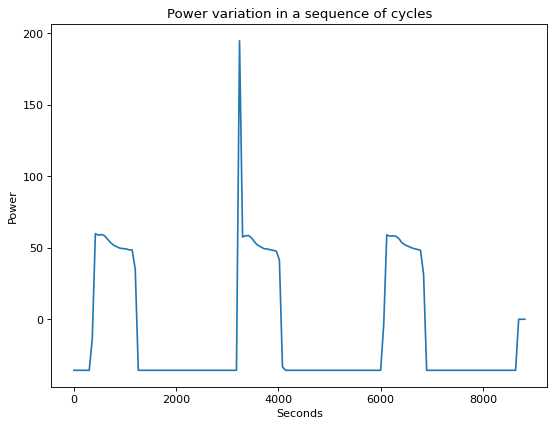

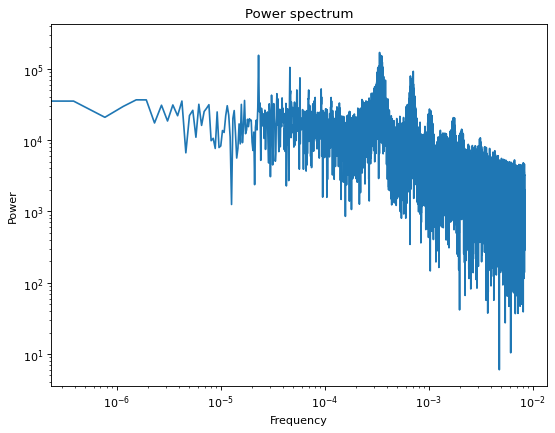

In [34]:
get_anomalies_periodicity(periodic_timeseries['Appliance1'][719:], periodic_timeseries['Time'][719:], "%Y-%m-%d %H:%M:%S", 43200, dataset_name)